In [2]:
import numpy as np
import os
import pandas as pd
import subprocess

from torch import nn

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from PIL import Image

from torchvision import transforms

import torch
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import confusion_matrix

## 1. Данные и их обработка
Скачаем данные с гитхаба, где располагается датасет. Нам нужна только папка images.

In [3]:
! git clone https://github.com/EdjeElectronics/TensorFlow-Object-Detection-API-Tutorial-Train-Multiple-Objects-Windows-10.git
! cp -r "TensorFlow-Object-Detection-API-Tutorial-Train-Multiple-Objects-Windows-10/images" images
! rm -r "TensorFlow-Object-Detection-API-Tutorial-Train-Multiple-Objects-Windows-10"


Cloning into 'TensorFlow-Object-Detection-API-Tutorial-Train-Multiple-Objects-Windows-10'...
remote: Enumerating objects: 1235, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 1235 (delta 17), reused 0 (delta 0), pack-reused 1199
Receiving objects: 100% (1235/1235), 57.70 MiB | 46.27 MiB/s, done.
Resolving deltas: 100% (627/627), done.


Папка images имеет следующую структру:  
- `train` &mdash; картинки для обучения, а также xml-файлы с разметкой, которые нам не нужны;
- `train_labels.csv` &mdash; таблица с разметкой картинок для обучения;
- `train` &mdash; картинки для тестирования, а также xml-файлы с разметкой, которые нам не нужны;
- `train_labels.csv` &mdash; таблица с разметкой картинок для тестирования.

Таблицы с разметкой имеют одинаковый формат. Посмотрим на таблицу с разметкой для обучения. Как вы можете заметить, здесь для каждого изображения указаны необходимые нам координаты ограничивающих прямоугльников или боксов, а также названия классов.

In [4]:
data = pd.read_csv("images/train_labels.csv")
data.head()

filename  width  height  class  xmin  ymin  xmax  ymax
0   cam_image1.jpg    480     270  queen   173    24   260   137
1   cam_image1.jpg    480     270  queen   165   135   253   251
2   cam_image1.jpg    480     270    ten   255    96   337   208
3  cam_image10.jpg    960     540    ten   501   116   700   353
4  cam_image10.jpg    960     540  queen   261   124   453   370

Сразу заметим, что картинки в датасете разного размера.

Определим функцию, которая по названию файла выдает лейбл и координаты боксов.

Всего в данных 6 классов карт. Добавим к ним класс фона `bg`. Он понадобится нам для работы с SSD. 

Посмотрим как выглядят наши данные в целом. Визуализируем картинки и соответствующие им боксы. Для этого будем использовать следующую функцию отрисовки. Вы можете далее изменять ее как вам будет удобнее.

In [5]:
def plot_boxes(
    boxes, labels, classes, ax, edgecolor='red', scores=None, threshold=None
):
    """
    Функция отрисовки bounding box-ов в задаче детекции.
    
    Аргументы:
      boxes -- массив боксов, которые задаются координатами
      xmin, ymin, xmax, ymax;
      labels -- лейблы классов;
      scores -- уверенность модели в детекции боксов;
      threshold -- порог отсечения боксов по threshold;
      ax -- полотно, на котором отрображена исходная картинка.
    """
    
    box_kwargs = dict(linewidth=2, fill=False, edgecolor=edgecolor, facecolor='none')
    bbox = dict(facecolor='white', alpha=0.5)
    annot_kwargs = dict(color='black', size=14, bbox=bbox)
    
    for i, box in enumerate(boxes):

        if (scores is not None) and (threshold is not None) and (scores[i] < threshold):
            continue

        left_x, top_y, right_x, bottom_y = box
        width = right_x - left_x + 1
        height = bottom_y - top_y + 1

        # Прямоугольная рамка
        box_patch = Rectangle((left_x, top_y), width=width, height=height, **box_kwargs)
        # Добавляем рамку к изображению
        ax.add_patch(box_patch)

        # Добавляем текст к фото справа сверху от рамки
        if scores is not None:
            ax.text(left_x, top_y, f"{classes[labels[i]]}, {scores[i]:.2f}", **annot_kwargs)
        else:
            ax.text(left_x, top_y, f"{classes[labels[i]]}", **annot_kwargs)

Визуализируем 20 картинок из тренировочных данных.

In [6]:
classes = ('bg', 'nine', 'ten', 'jack', 'queen', 'king', 'ace')

label_map = {
    'bg': 0, 'nine': 1, 'ten': 2, 'jack': 3, 'queen': 4, 'king': 5, 'ace': 6
}
def get_file_labels_boxes(data, file):
    """
    Функция, которая по названию файла выдает лейбл и координаты боксов.
    
    Аргументы:
      data -- датафрейм с данными;
      file -- название файла.
      
    Возвращает:
      labels и boxes -- лейблы классов и координаты босков 
      в формате xmin, ymin, xmax, ymax.
    """
    
    part_data = data.where(data["filename"] == file).dropna(how='any', axis=0)
    labels = [label_map[class_] for class_ in part_data["class"].values]
    boxes = part_data[["xmin", "ymin", "xmax", "ymax"]].values
    return labels, boxes

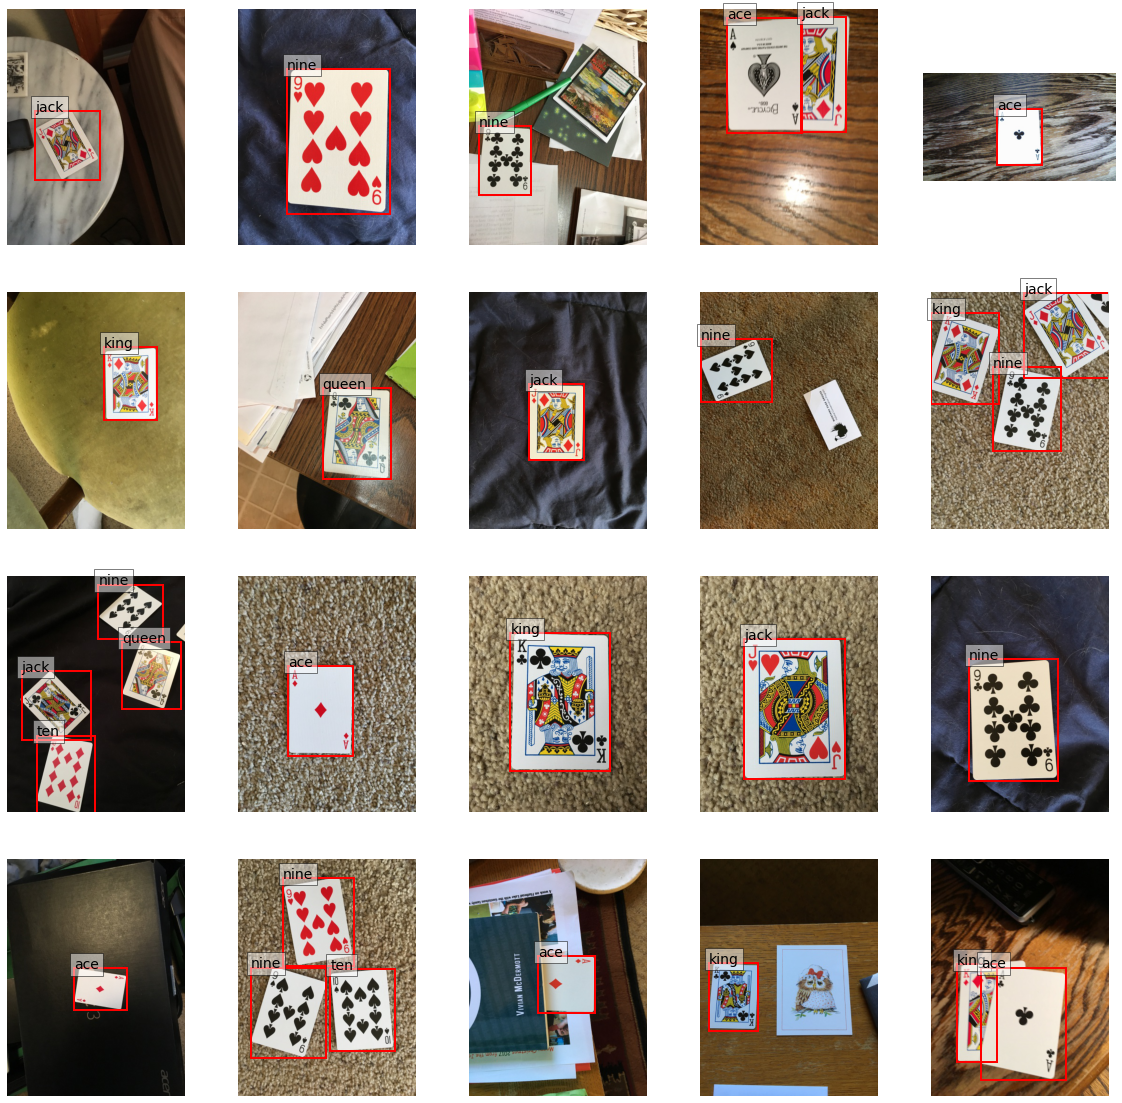

In [7]:
files = os.listdir("images/train")
fig, axes = plt.subplots(4, 5, figsize=(20,20))

i = 0  # Итератор по изображениям
j = 0  # Итератор по файлам

while i < 20:

    file = files[j]
    j += 1

    # Выбираем только картинки
    if file[-4:].lower() != ".jpg":
        continue
    img = Image.open(os.path.join("images/train", file))

    # Получаем лейбля и боксы, соотв. картинке
    labels, boxes = get_file_labels_boxes(data, file)

    # Визуализируем
    ax = axes[i // 5, i % 5]
    ax.imshow(img)
    plot_boxes(boxes, labels, classes, ax)
    ax.axis("off")

    i += 1

Вспомним, что для модели SSD300, которую вы будете применять, нужны на вход картинки размера 300 x 300. Причем здесь нам не помогут разные трансформации из `torchvision.transforms`, так как нам нужно изменять еще и боксы. К нам в помощь приходит библиотека [Albumentations](https://albumentations.ai/docs/). Подробнее посмотреть как работать с библиотекой в случае детекции можно [тут](https://albumentations.ai/docs/examples/example_bboxes/) и [тут](https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/).

In [8]:
! pip install --upgrade albumentations==0.5.2

     |████████████████████████████████| 81kB 7.7MB/s 
     |████████████████████████████████| 37.6MB 68kB/s 
     |████████████████████████████████| 952kB 46.7MB/s 
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [9]:
import albumentations as A

In [10]:
def spec_crop(image, boxes):
    """
    Функция, которая обрезает изображения до квадрата так, 
    чтобы все боксы по возможности остались внутри квадрата.
    Полученные картинки приводятся к размеру 300x300.
    """

    # Вычисляем границы всех боксов вместе
    x_min = boxes[:, 0].min()
    y_min = boxes[:, 1].min()
    x_max = boxes[:, 2].max()
    y_max = boxes[:, 3].max()

    # Ширина и высота изображения
    h, w = image.size
    # Размер квадрата, до которого мы обрежем изображение
    size = min(h, w)
    half_size = size // 2

    # x-координата центра прямоугольника, ограничивающего все боксы
    x_ctr = (x_max - x_min) // 2 + x_min
    # По ней мы вычисляем x_min и x-max -- координаты квадрата,
    # который мы вырежем из исходного изображения,
    # чтобы получить квадратное изображение.
    if x_ctr < half_size:
        x_min = 0
        x_max = size - 1
    elif x_ctr + half_size >= h:
        x_max = h - 1
        x_min = x_max - size + 1
    else:
        x_min = x_ctr - half_size
        x_max = int(x_min + size) - 1
    
    # y-координата центра прямоугольника, ограничивающего все боксы
    y_ctr = (y_max - y_min) // 2 + y_min
    # По ней мы вычисляем y_min и y-max -- координаты квадрата,
    # который мы вырежем из исходного изображения,
    # чтобы получить квадратное изображение.
    if y_ctr < half_size:
        y_min = 0
        y_max = size - 1
    elif y_ctr + half_size >= w:
        y_max = w - 1
        y_min = y_max - size + 1
    else:
        y_min = y_ctr - half_size
        y_max = int(y_min + size) - 1

    # Приводим все координаты к int
    x_min, y_min, x_max, y_max = int(x_min), int(y_min), int(x_max), int(y_max)
    
    # Обрезаем изображение до квадрата и изменяем размер, полученного изображения
    transform = A.Compose(
        [
            A.Crop(x_min, y_min, x_max, y_max),
            A.Resize(300, 300),
        ], 
        # Обязательно нужно указать bbox_params, чтобы боксы тоже трансформировались.
        # format -- формат, в котором подаются координаты для боксов
        # в нашем случае 'pascal_voc', то есть в порядке: x_min, y_min, x_max, y_max.
        # label_fields -- поля, куда можно задавать леблы классов,
        # при желании полей с классами может быть несколько.
        bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels'])
    )
    transformed = transform(image=np.array(image), bboxes=boxes, labels=labels)
    image, boxes = transformed["image"], transformed["bboxes"]

    return image, boxes

In [11]:
def change_file_boxes(data, file, boxes):
    """Функция, которая изменяет координаты боксов."""
    data.loc[data["filename"] == file, ["xmin", "ymin", "xmax", "ymax"]] = boxes

In [12]:
dir = "images"
res_dir = "cropped_images"
os.makedirs(res_dir, exist_ok=True)

for part in ["train", "test"]:
    # Создаем папку, если ее нет
    os.makedirs(os.path.join(res_dir, part), exist_ok=True)

    # Названия файлов с картинками и таблица с разметкой
    files = os.listdir(os.path.join(dir, part))
    data = pd.read_csv(os.path.join(dir, f"{part}_labels.csv"))

    for file in files:
        
        # Выбираем только картинки
        if file[-4:].lower() != ".jpg":
            continue
        image = Image.open(os.path.join(dir, part, file))
        
        # Получаем лейблы и координаты боксов
        labels, boxes = get_file_labels_boxes(data, file)

        # Обрезаем картинку
        image, boxes = spec_crop(image, boxes)

        # Сохраняем результат обрезки
        plt.imsave(os.path.join(res_dir, part, file), image)
        change_file_boxes(data, file, boxes)

    data.to_csv(os.path.join(res_dir, f"{part}_labels.csv"))

In [14]:
def iou(predicted_mask_batch, target_mask_batch):
    """ Считает IoU для всех элементов батча 
    Размер входа (размер батча, ширина, высота) """ 
    
    iou = np.logical_and(predicted_mask_batch, target_mask_batch).sum(axis=(1, 2)) / np.logical_or(predicted_mask_batch, target_mask_batch).sum(axis=(1, 2))
    return iou

## 3. Обучение SDD300

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
! git clone https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection.git

Cloning into 'a-PyTorch-Tutorial-to-Object-Detection'...
remote: Enumerating objects: 249, done.
remote: Total 249 (delta 0), reused 0 (delta 0), pack-reused 249
Receiving objects: 100% (249/249), 175.95 MiB | 48.52 MiB/s, done.
Resolving deltas: 100% (117/117), done.


In [17]:
for part_path in os.listdir('a-PyTorch-Tutorial-to-Object-Detection'):
    path = os.path.join('a-PyTorch-Tutorial-to-Object-Detection', part_path)
    ! cp -r $path $part_path

In [18]:
! rm -r a-PyTorch-Tutorial-to-Object-Detection

In [19]:
# Тут сохраняем измененные модули
! ls drive/MyDrive/SSD_cards

arial.zip				      datasets.py  out.jpg
checkpoint_ssd300_not_pretrained_vgg.pth.tar  detect.py    train.py
checkpoint_ssd300.pth.tar		      eval.py	   utils.py
create_data_lists.py			      model.py


In [20]:
! cp drive/MyDrive/SSD_cards/* ./

In [21]:
! unzip arial.zip

Archive:  arial.zip
  inflating: arial.ttf               


In [32]:
! python3 train.py


Loaded base model.

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Epoch: [0][0/37]	Batch Time 3.803 (3.803)	Data Time 0.011 (0.011)	Loss 19.9152 (19.9152)	
Epoch: [1][0/37]	Batch Time 0.284 (0.284)	Data Time 0.005 (0.005)	Loss 8.6814 (8.6814)	
Epoch: [2][0/37]	Batch Time 0.288 (0.288)	Data Time 0.005 (0.005)	Loss 6.8926 (6.8926)	
Epoch: [3][0/37]	Batch Time 0.293 (0.293)	Data Time 0.005 (0.005)	Loss 4.9327 (4.9327)	
Epoch: [4][0/37]	Batch Time 0.292 (0.292)	Data Time 0.004 (0.004)	Loss 4.5323 (4.5323)	
Epoch: [5][0/37]	Batch Time 0.295 (0.295)	Data Time 0.006 (0.006)	Loss 4.5232 (4.5232)	
Epoch: [6][0/37]	Batch Time 0.292 (0.292)	Data Time 0.005 (0.005)	Loss 3.6922 (3.6922)	
Epoch: [7][0/37]	Batch Time 0.292 (0.292)	Data Time 0.004 (0.004)	Loss 3.9765 (3.9765)	
Epoch: [8][0/37]	Batch Time 0.297 (0.297)	Data Time 0.005 (0.005)	Loss 

In [ ]:
%run train.py

In [23]:
! python3 detect.py


Loaded checkpoint from epoch 122.

/content/model.py:501: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
  image_boxes.append(class_decoded_locs[1 - suppress])
/content/model.py:503: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
  image_scores.append(class_scores[1 - suppress])


In [30]:
! touch plot_test.py

In [24]:
img_path = './out.jpg'
out = Image.open(img_path, mode='r')

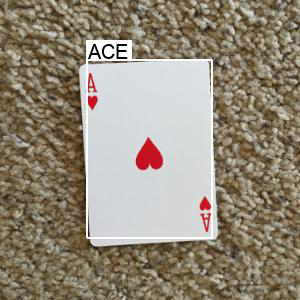

In [52]:
out

In [24]:
cp arial.zip datasets.py out.jpg train.py eval.py model.py detect.py utils.py create_data_lists.py -d drive/MyDrive/SSD_cards

In [38]:
! cp checkpoint_ssd300.pth.tar -d drive/MyDrive/SSD_cards

In [46]:
! python eval.py

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Evaluating:   0% 0/9 [00:00<?, ?it/s]/content/model.py:501: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
  image_boxes.append(class_decoded_locs[1 - suppress])
/content/model.py:503: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
  image_scores.append(class_scores[1 - suppres

In [25]:
label_map = {
    'bg': 0, 'nine': 1, 'ten': 2, 'jack': 3, 'queen': 4, 'king': 5, 'ace': 6
}

In [28]:
pd.DataFrame(index=label_map.keys(), columns=label_map.keys(), data=0)

bg  nine  ten  jack  queen  king  ace
bg      0     0    0     0      0     0    0
nine    0     0    0     0      0     0    0
ten     0     0    0     0      0     0    0
jack    0     0    0     0      0     0    0
queen   0     0    0     0      0     0    0
king    0     0    0     0      0     0    0
ace     0     0    0     0      0     0    0

## 4. Обучение без предобученного backbone
Попробуйте не использовать предобученные веса из VGG16. Сравните скорость обучения полученной сети с предыдущей.

- Поменяем в модуле model.py  
self.load_layers(pretrained=True) на self.load_layers(pretrained=False).
- В функции save_checkpoint модуля utils.py установим  
filename = 'drive/MyDrive/SSD_cards/checkpoint_ssd300_not_pretrained_vgg.pth.tar'

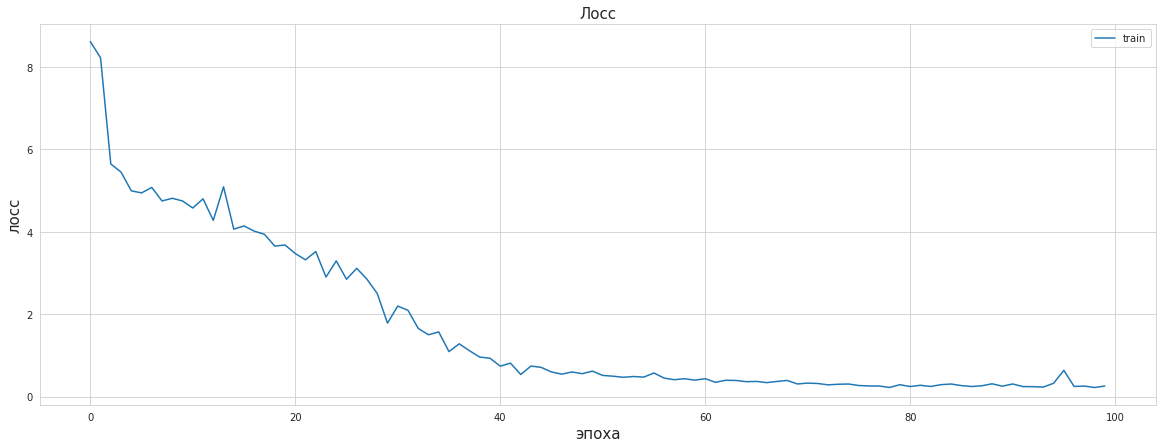

Epoch: [100][0/37]	Batch Time 0.655 (0.655)	Data Time 0.005 (0.005)	Loss 0.2774 (0.2774)	


In [ ]:
%run train.py

In [47]:
! python eval.py

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Evaluating:   0% 0/9 [00:00<?, ?it/s]/content/model.py:501: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
  image_boxes.append(class_decoded_locs[1 - suppress])
/content/model.py:503: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
  image_scores.append(class_scores[1 - suppres

## 7. Применение модели в реальной жизни
Примените лучшую модель к своим фото карт, главное, не берите фото из тренировочных и тестовых данных. Оцените качество.

In [32]:
%run detect.py


Loaded checkpoint from epoch 22.



/content/model.py:501: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
  image_boxes.append(class_decoded_locs[1 - suppress])
/content/model.py:503: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
  image_scores.append(class_scores[1 - suppress])


In [33]:
img_path = './out.jpg'
out = Image.open(img_path, mode='r')

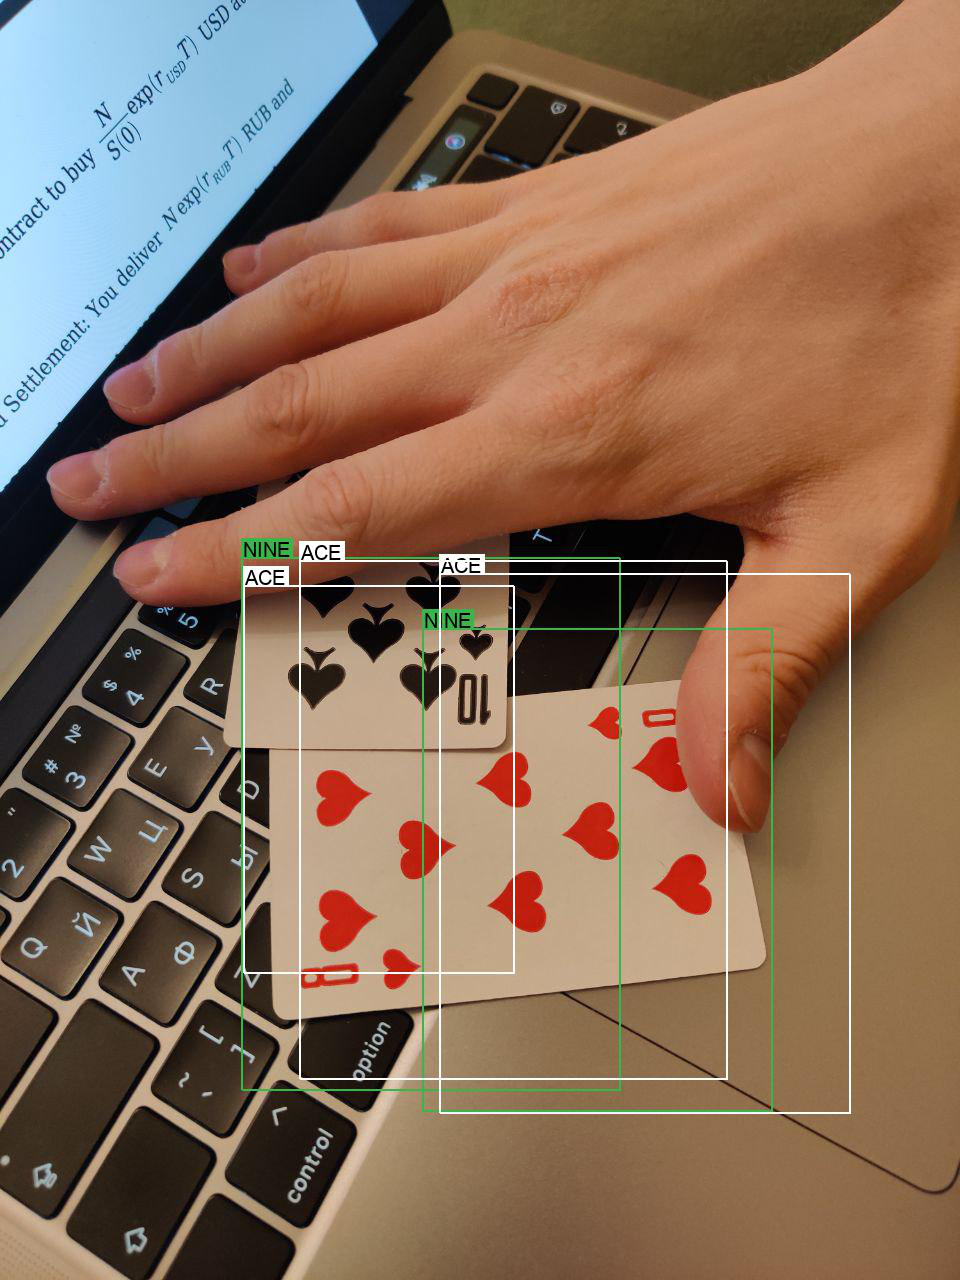

In [34]:
out


Loaded checkpoint from epoch 22.



/content/model.py:501: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
  image_boxes.append(class_decoded_locs[1 - suppress])
/content/model.py:503: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
  image_scores.append(class_scores[1 - suppress])


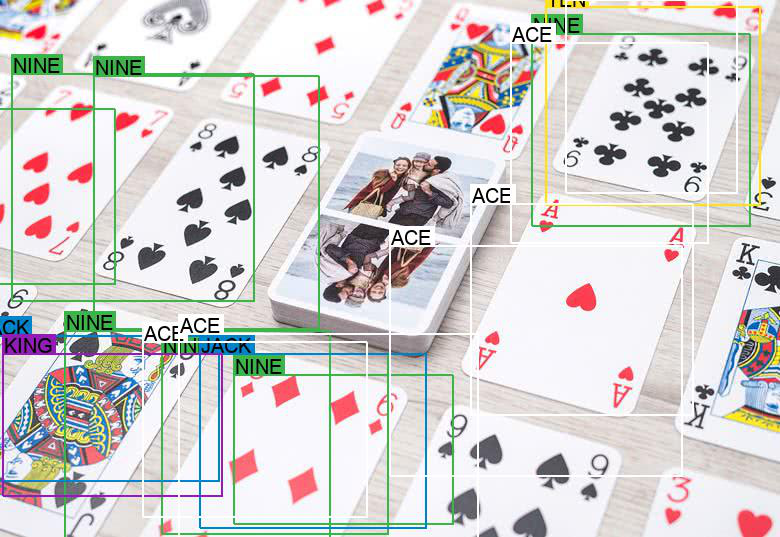

In [37]:
%run detect.py
Image.open('./out.jpg', mode='r')

Так как в данных все карты был из одной колоды и сняты на одну камеру, то в жизни модель работает плохо. Хотя она детектит карты, но не все и неправильно определяет ранги и боксы